In [1]:
from efficient_network import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

token = "D-Wave API token"

### 0. Select station locations based on MWIS
We choose a set of stations from 100 locations on a grid such that the total weight (traffic volume) of the chosen stations is maximized while all neighboring stations are at least $r_{min}$ units apart in distance. 

In [2]:
# calculate the distance of two nodes in a grid of length L
def calc_dist(x,y,L): 
    return np.sqrt((x%L-y%L)**2+(x//L-y//L)**2)

# create distance matrix of 100 locations on a 10 x 10 grid
D100 = np.zeros((100,100))
for i in range(100):
    for j in range(i+1,100):
        D100[i,j] = 5*calc_dist(i,j,10)  # assume L/10 = 5
        D100[j,i] = 5*calc_dist(i,j,10)

In [ ]:
# generate random weights for all locations
W_loc100 = np.random.randint(1,50,100)
# distance threshold
r_min = 6
loc100 = choose_location(100, W_loc100, D100, r_min, token)

In [ ]:
# visuallze the chosen stations (red nodes)
G100= nx.Graph()
for i in range(10):
    for j in range(10):
        G100.add_node(10*i+j,pos=(i,j))
for i in range(10):
    for j in range(9):
        G100.add_edge(10*i+j,10*i+j+1,weight=5)
for j in range(10):
    for i in range(9):
        G100.add_edge(10*i+j,10*(i+1)+j,weight=5)
pos=nx.get_node_attributes(G100,'pos')
colormap=["royalblue"]*100
for i in loc100:
    colormap[i] ="red"
fig = plt.figure(figsize=(20,16))
nx.draw(G100,pos,with_labels=True,node_size = 70*W_loc100,node_color=colormap)

### 1. Divide the stations into $2$ or $2^{n}$ groups to reduce the problem size
Given the location of stations and their distance matrix, we want to divide the stations into 2 or more groups such that the sum of the total length of each group's distance matrix is minimized. Here we assume we have 100 stations and we want to divide them into 4 groups.

In [ ]:
# generate random distance matrix
W100 = np.random.randint(1,100,size=(100,100))
# first divide into 2 groups
divide100 = divide_region(100,W100,token)

In [ ]:
# visualize the division
g_div = nx.Graph()
n=100
for i in range(n):
    g_div.add_node(i)
for j in range(n):
    for k in range(j+1,n):
        g_div.add_edge(j,k)
        
for i in range(n):
    for j in range(i+1,n):
        g_div[i][j]["weight"] = W100[i][j]

color_map = ["blue"]*n
for i in divide100[0]:
    color_map[i] = "red"  
    
pos100 = nx.spring_layout(G100,weight="length")
plt.figure(figsize=(6,4))
nx.draw(g_div,pos = pos100,node_color = color_map,with_labels=True,width=0.1)


In [ ]:
# we divide each of the two groups into two smaller subgroups

# generate the distance matrix for each group
group1 = make_W(W100,divide100[0])
group2 = make_W(W100,divide100[1])

divide50_1 = divide_region(50,group1)
divide50_2 = divide_region(50,group2)

# we end up with 4 subgroups
subgroup1 = divide100[0][divide50_1[0]]
subgroup2 = divide100[0][divide50_1[1]]
subgroup3 = divide100[1][divide50_2[0]]
subgroup4 = divide100[1][divide50_2[1]]

### 2. Search for connected graphs with minimal total distance
We select only a minimal set of edges from a fully-connected network such that the total distance of the network is minimized. This optimization process is applied to all four subgroups. Besides, we also impose the constraint that the biggest stations need to have at least 4 connections, while the smallest cannot have more than 2 connections.

In [ ]:
# calculate the distance matrices of the four subgroups
distance_matrices = [make_W(W100,nodes) for nodes in [subgroup1,subgroup2,subgroup3,subgroup4]]

# generate random weights (traffic volume) for the stations
w100 = np.random.randint(1,25,100)

# group the traffic volumes by subgroups
traffic_volumes = [w100[sub] for sub in [subgroup1,subgroup2,subgroup3,subgroup4]]

# create a list of candidate connected graphs for each subgroup
graph100_25 = [mini_overall_dist(25,distance_matrices[i],traffic_volumes[i]) for i in range(4)]

# check the overall length of each candidate solution for each subgroup
for i in range(4):
    print(f"subnetwork_{i+1} candidate solutions' overall lengths:")
    print(overall_length(graph100_25[i],distance_matrices[i]))

# retrieve the best solution of each subgroup
# 1. only consider the overall distance
best_index = [np.argmin(overall_length(graph100_25[i],distance_matrices[i])) for i in range(4)]
# 2. consider overall distance + average shortest path length
best_index = [np.argmin(overall_length(graph100_25[i],distance_matrices[i])*avg_path_length(graph100_25[i],distance_matrices[i])) for i in range(4)]
best_subnetworks = [graph100_25[i][best_index[i]] for i in range(4)]

#map the indices of best_subnetworks to the actual indices of the original graph G100
subgroups=[subgroup1,subgroup2,subgroup3,subgroup4]
subnetworks = [[(subgroups[i][edge[0]],subgroups[i][edge[1]]) for edge in sub] for i,sub in enumerate(best_subnetworks)]

In [ ]:
# turn the chosen subnetworks into nx.Graph objects for visualization.
g100_25 = [make_nx_graph(subnetworks[i],W100,subgroups[i]) for i in range(4)]

# assemble all subnetworks 
F12 = nx.union(g100_25[0],g100_25[1])
F123 = nx.union(F12,g100_25[2])
g100 = nx.union(F123,g100_25[3])
color_map = ["blue"]*100
for i in subgroup1:
    color_map[i] = "red" 
for i in subgroup2:
    color_map[i] = "lightcoral" 
for i in subgroup3:
    color_map[i] = "royalblue"
nx.draw(g100,pos=pos100,node_color=color_map,with_labels=True)

### Connect subnetworks
Find a connection between every pair subnetworks to form the complete optimal transport network. This is achieved by selecting the connection that leads to the minimal avergae shortest path length of the combined subnetworks.

In [ ]:
new_connections = []
for k in range(4):
    for s in range(k+1,4):
        avg =[]
        for i in list(g100_25[k].nodes):
            for j in list(g100_25[s].nodes):
                F12 = nx.union(g100_25[k],g100_25[s])  # pair up two subnetworks
                F12.add_edge(i,j,weight=W100[i,j])
                avg.append(nx.average_shortest_path_length(F12,weight="weight")) # calculate average shortest path
        mini = np.argmin(avg)  # pick the connection that minimizes the average shortest path length
        con1 = list(g100_25[k].nodes)[mini//25]
        con2 = list(g100_25[s].nodes)[mini%25]
        new_connections.append((con1,con2))
        
print("connections between subnetworks:", new_connections)

In [ ]:
# combine all the subnetworks with the chosen connections to form the optimized transport network
optimized_network = nx.union_all(g100_25)
weights = [W100[i,j] for i,j in new_connections]
for index,edge in enumerate(new_connections):
    optimized_network.add_edge(edge[0],edge[1],weight=weights[index])
    
plt.figure(figsize=(10,6))
pos_final = nx.spring_layout(optimized_network)
nx.draw(optimized_network,pos = pos_final, with_labels=True,node_size=150)

### 3. Quantum Shortest Path Algorithm
Find the shortest path connecting two stations in a network using quantum annealing.

In [ ]:
graph100 = []
for subnetwork in subnetworks:
    for edge in subnetwork:
        graph100.append(edge)

# shortest path from node 10 to 50
short10_50 = shortest_path(W100,graph100,start=10,end=50) 
print(f"shortest path from 10 to 50: {short10_50[0]}  distance = {short10_50[1]}")

# all the shortest paths starting from 1
short100 = ss_shortest_path(W100,graph100,start=1) 

# print the first 10 paths
for i in range(10):
    print(f"shortest path from 1 to {i}: {short100[0][i]}  distance = {short100[1][i]}")
    

## 4. Assign lines to the transport network
Strategy 1: Minimize the average transfer frequency using a tailored genetic algorithm

Strategy 2: Minimize the variance in the traffic volumes of metro lines

Strategy 3: Minimize the variance in the lengths of metro lines

In [2]:
# Consider a 30-station transport network
graph30 = [(0, 27), (1, 21), (1, 29), (2, 5), (3, 5), (3, 19), (4, 16), (4, 24), (5, 12), (5, 15), (6, 8), (7, 22), (7, 24), (8, 17), (9, 19), (9, 28), (10, 13), (11, 16), (13, 24), (13, 27), (14, 19), (17, 22), (17, 26), (17, 28), (18, 24), (19, 25), (20, 28), (23, 26), (27, 29)]
W30 = np.random.randint(1,30,size=(30,30))
g30 = make_nx_graph(graph30, W30, range(30))

# Assign lines based on transfer frequency
popu_size = 1000
line_plan = train_line_genetic(g30,popu_size,W30,selection_rate=0.3,max_iteration=100,cutoff_std=0.1)

minimum cost: 0.9011494252873563
optimal lines: [[11, 16, 4, 24, 18], [20, 28], [13, 10], [14, 19, 25], [23, 26, 17, 8, 6], [27, 0], [2, 5, 15], [21, 1, 29, 27, 13, 24, 7, 22, 17, 28, 9, 19, 3, 5, 12]]
iteration: 17


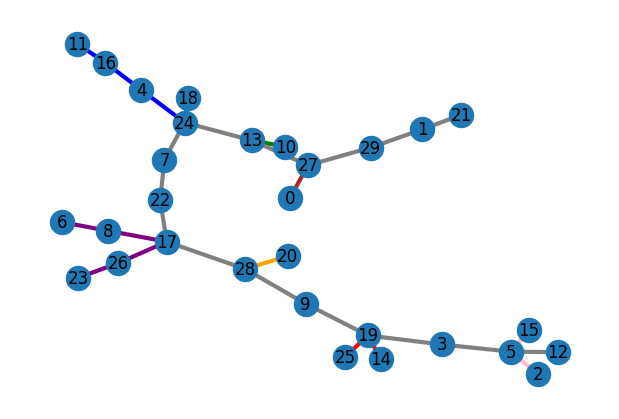

In [ ]:
# visualize the line plan
g30 = nx.Graph()

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

for i in range(30):
    g30.add_node(i)
for j in graph30:
    for idx, line in enumerate(line_plan[0]):
        if j[0] in line and j[1] in line:
            color = colors[idx]
    g30.add_edge(j[0],j[1],color=color)

for i in graph30:
    g30[i[0]][i[1]]["weight"] = W30[i[0]][i[1]]

edges = g30.edges()
edge_colors = [g30[u][v]['color'] for u,v in edges]

pos30 = nx.spring_layout(g30,weight="length") 
plt.figure(figsize=(6,4))
nx.draw(g30,pos = pos30,edge_color=edge_colors,with_labels=True,width=3)

In [ ]:
# Assign lines based on equal traffic volume
w30 = np.random.randint(1,30,30)
line_plan2 = train_line_equal_load(w30,g30,token)
print("line plan 2:", line_plan2)

In [ ]:
# Assign lines based on equal length
line_plan3 = train_line_equal_length(30,g30,token)
print("line plan 3:", line_plan3)